# Detecting COVID-19 on patients, using X-ray images
An Image Classification Model is trained, using the VGG16 architecture and using Tensorflow 2.
Because of the very small dataset, I decided to use transfer learning, with the imagenet pretrained weights.

The infected X-ray images i used, where uploaded by Dr. Joseph Paul Cohen on the following GitHub repository: https://github.com/ieee8023/covid-chestxray-dataset

The healthy X-ray images i use to train the model are taken from the following Kaggle competition: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from IPython.display import Image as disp_image 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 

## Data

In [30]:
img_height = 256
img_width = 256
channels = 3
batch_size = 8
epochs = 20

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   #horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    './dataset/training',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'binary',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    './dataset/training',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'binary',
     subset = 'validation',
     shuffle=False)

test_set = train_datagen.flow_from_directory(
    './dataset/test',
     target_size = (img_height, img_width),
     batch_size = 1,
     shuffle = False,
     class_mode = 'binary')

print(training_set.class_indices)

Found 108 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
{'covid': 0, 'healthy': 1}


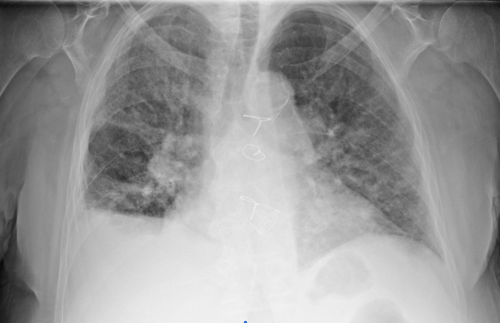

In [3]:
# Covid image example
img_files = os.listdir('dataset/training/covid')
img_path = img_files[np.random.randint(0,len(img_files))]

img = Image.open('dataset/training/covid/{}'.format(img_path))
img.thumbnail((500, 500))
display(img)

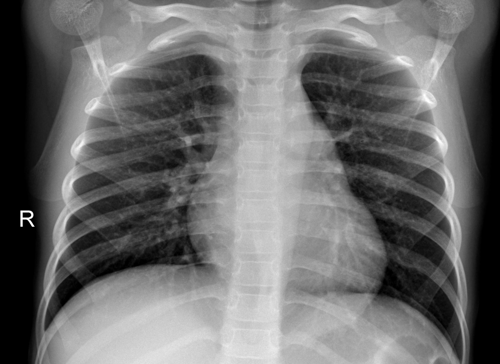

In [4]:
# Healthy image example
img_files = os.listdir('dataset/training/healthy')
img_path = img_files[np.random.randint(0,len(img_files))]

img = Image.open('dataset/training/healthy/{}'.format(img_path))
img.thumbnail((500, 500))
display(img)

## Model

In [31]:
# VGG16
model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, channels))

for layer in model.layers[:-5]:
    layer.trainable = False

top_model = Sequential()
top_model.add(model)
top_model.add(Flatten())
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

print(model.summary())
print(top_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [32]:
# Compile Model
top_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6),
                  metrics=['accuracy'])

# Save Model
history = top_model.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=epochs,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size)

# Save Model
top_model.save('output/covid_model.h5', save_format='h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 3 steps
Epoch 1/20
13/13 [==============================] - 22s 2s/step - loss: 0.8601 - accuracy: 0.5800 - val_loss: 0.4307 - val_accuracy: 0.8750
Epoch 2/20
13/13 [==============================] - 22s 2s/step - loss: 0.5752 - accuracy: 0.7000 - val_loss: 0.2143 - val_accuracy: 0.9167
Epoch 3/20
13/13 [==============================] - 24s 2s/step - loss: 0.3820 - accuracy: 0.8300 - val_loss: 0.1398 - val_accuracy: 1.0000
Epoch 4/20
13/13 [==============================] - 25s 2s/step - loss: 0.2890 - accuracy: 0.8700 - val_loss: 0.1417 - val_accuracy: 0.9583
Epoch 5/20
13/13 [==============================] - 24s 2s/step - loss: 0.2154 - accuracy: 0.9038 - val_loss: 0.2031 - val_accuracy: 0.9167
Epoch 6/20
13/13 [==============================] - 22s 2s/step - loss: 0.2211 - accuracy: 0.9000 - val_loss: 0.4743 - val_accuracy: 0.8333
Epoch 7/20
13/13 [==============================] - 22s 2s/step - los

## Model Performance

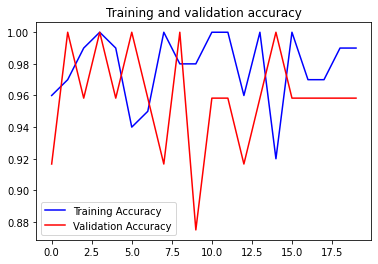

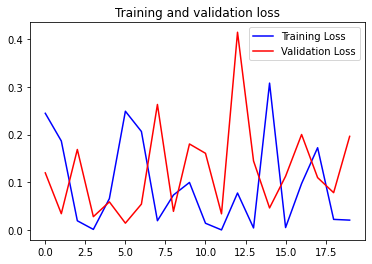

In [15]:
# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [33]:
# Model Performance on test set
test_pred = top_model.evaluate_generator(test_set,
                                        steps=test_set.n//batch_size,
                                        use_multiprocessing=False,
                                        verbose=1)

print('Test loss: ', test_pred[0])
print('Test accuracy: ', test_pred[1])

  ...
    to  
  ['...']
2/2 [==============================] - 0s 210ms/step - loss: 0.0419 - accuracy: 1.0000
Test loss:  0.04190307867247611
Test accuracy:  1.0


18/18 [==============================] - 3s 140ms/step


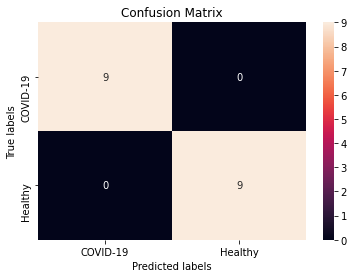

In [34]:
test_pred = top_model.predict(test_set,
                              steps=test_set.n,
                              use_multiprocessing=False,
                              verbose=1)

test_pred_class = (test_pred >= 0.5)*1

# Confusion Matrix
cm = confusion_matrix(test_set.classes,
                      test_pred_class)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COVID-19', 'Healthy']); ax.yaxis.set_ticklabels(['COVID-19', 'Healthy']);

In [35]:
# Classification Report
print(classification_report(test_set.classes,
                     test_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



# Multiclass Model
For this model I also include the `pneumonia` class, to test if the model is still performing well when we add another symptom.

The images are also from the Kaggle competition, actually that competition was to classify in `healthy` and `pneumonia`

## Data

In [20]:
img_height = 256
img_width = 256
channels = 3
batch_size = 8
epochs = 20

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   #horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('./multiclass_dataset/training',
                                                 target_size = (img_height, img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset = 'training',
                                                 shuffle=True)

validation_set = train_datagen.flow_from_directory('./multiclass_dataset/training',
                                                 target_size = (img_height, img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset = 'validation',
                                                 shuffle=False)

test_set = train_datagen.flow_from_directory('./multiclass_dataset/test',
                                                 target_size = (img_height, img_width),
                                                 batch_size = 1,
                                                 shuffle = False,
                                                 class_mode = 'categorical')

print(training_set.class_indices)

Found 164 images belonging to 3 classes.
Found 38 images belonging to 3 classes.
Found 27 images belonging to 3 classes.
{'covid': 0, 'healthy': 1, 'pneumonia': 2}


## Model

In [21]:
# VGG16
model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, channels))

for layer in model.layers[:-5]:
    layer.trainable = False

top_model = Sequential()
top_model.add(model)
top_model.add(Flatten())
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(len(training_set.class_indices), activation='softmax'))

print(model.summary())
print(top_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [22]:
# Compile Model
top_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6),
                  metrics=['accuracy'])

save_best = ModelCheckpoint('output/covid_pneumonia_model.h5', monitor='val_loss', verbose=0, save_best_only=True)

# Train Model
history = top_model.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=epochs,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks=[save_best])

# Save Model
top_model.save('output/covid_pneumonia_model.h5', save_format='h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 4 steps
Epoch 1/20
20/20 [==============================] - 33s 2s/step - loss: 1.2224 - accuracy: 0.4487 - val_loss: 0.8010 - val_accuracy: 0.6250
Epoch 2/20
20/20 [==============================] - 34s 2s/step - loss: 0.8226 - accuracy: 0.6667 - val_loss: 0.7449 - val_accuracy: 0.5938
Epoch 3/20
20/20 [==============================] - 36s 2s/step - loss: 0.4538 - accuracy: 0.8462 - val_loss: 0.4207 - val_accuracy: 0.8750
Epoch 4/20
20/20 [==============================] - 35s 2s/step - loss: 0.4916 - accuracy: 0.8269 - val_loss: 0.5009 - val_accuracy: 0.8125
Epoch 5/20
20/20 [==============================] - 34s 2s/step - loss: 0.4811 - accuracy: 0.8205 - val_loss: 0.6609 - val_accuracy: 0.8125
Epoch 6/20
20/20 [==============================] - 39s 2s/step - loss: 0.3646 - accuracy: 0.8782 - val_loss: 0.4452 - val_accuracy: 0.8750
Epoch 7/20
20/20 [==============================] - 36s 2s/step - los

## Model Performance

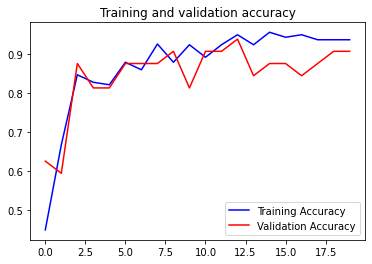

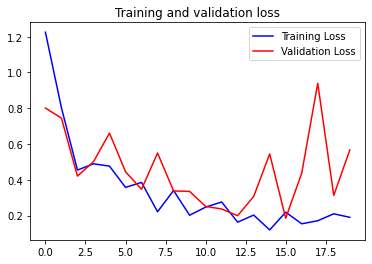

In [23]:
# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

27/27 [==============================] - 4s 130ms/step


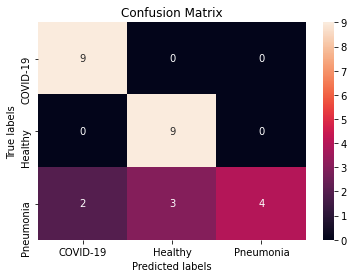

In [24]:
test_pred = top_model.predict(test_set,
                              steps=test_set.n,
                              use_multiprocessing=False,
                              verbose=1)

test_pred_class = np.argsort(test_pred)[:,2]

# Confusion Matrix
cm = confusion_matrix(test_set.classes,
                      test_pred_class)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COVID-19', 'Healthy', 'Pneumonia']); ax.yaxis.set_ticklabels(['COVID-19', 'Healthy', 'Pneumonia']);

In [25]:
# Classification Report
print(classification_report(test_set.classes,
                     test_pred_class))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.75      1.00      0.86         9
           2       1.00      0.44      0.62         9

    accuracy                           0.81        27
   macro avg       0.86      0.81      0.79        27
weighted avg       0.86      0.81      0.79        27



In [26]:
# Accuracy
accuracy_score(test_set.classes,
                     test_pred_class)

0.8148148148148148